Install

In [1]:
#test
#(studiolab) studio-lab-user@default:~/sagemaker-studiolab-notebooks/AI-OT24$ tensorboard --logdir logs/
#!pip install -q ib_insync numpy pandas yfinance matplotlib ta seaborn gymnasium stable-baselines3 sb3-contrib tensorflow scikit-learn quantstats imitation fredapi typing


Install requirements and import all functions

In [1]:
import os
os.chdir("/home/studio-lab-user/sagemaker-studiolab-notebooks/AI-OT24/Reinforcement-Learning-Stock-Porfolio-Managment")
!pip install -q -r requirements.txt

In [2]:
import sys
sys.path.append('./utils')
import trading_functions  # Import your library
import inspect  # Used to inspect the module

# Get all functions from the library
all_functions = [func for func, obj in inspect.getmembers(trading_functions) if inspect.isfunction(obj)]

# Print the function names
print("Functions in the 'trading_functions' library:")
for function in all_functions:
    print(function)

2024-12-13 04:18:52.936582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Functions in the 'trading_functions' library:
HER
accuracy_score
bin_reward_func
calculate_accuracy
check_env
clear_output
collect_expert_data
create_env
create_env_unique
create_evaluation_env
create_training_env
evaluate_all
evaluate_best
evaluate_buy
evaluate_model
evaluate_policy
evaluate_various
is_significant_reward_improvement
linear_schedule
lnr_reward_func
make_vec_env
save_model
smp_reward_func
sqh_reward_func
sqs_reward_func
stp_reward_func
train_model
train_test_split


In [3]:
import sys
sys.path.append('./utils')
from trading_functions import *
#from trading_functions import linear_schedule, TradingEnvUnique, TradingEnvUniqueMultiple, create_env, create_env_unique, evaluate_best, evaluate_buy, evaluate_model, evaluate_various, evaluate_all

Import

In [4]:
# Core Libraries
import os
import sys
import time
import datetime
import warnings
#warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = info, 2 = warnings, 3 = errors

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# Financial Data
import yfinance as yf
import quantstats as qs
import ta

# Machine Learning - Supervised Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Machine Learning - Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy

# Reinforcement Learning and Environments
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, DDPG, DQN, HER, PPO, SAC, TD3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import (
    EvalCallback, StopTrainingOnRewardThreshold, StopTrainingOnNoModelImprovement
)
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecCheckNan
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from sb3_contrib import ARS, MaskablePPO, RecurrentPPO, QRDQN, TRPO

# Imitation Learning
from imitation.algorithms import bc
from imitation.testing.reward_improvement import is_significant_reward_improvement
from imitation.data.types import Transitions

# Interactive Brokers API
from ib_insync import *

from typing import Callable

from collections import Counter

clear_output()


API Fred

In [5]:
from fredapi import Fred
fred = Fred(api_key='xxxxxxxxxxxxxxx')

Testing

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import tensorflow as tf

# Step 1: Download Data
stocks = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
data = yf.download(stocks, start='2017-01-01', end='2022-12-30', group_by='ticker')

# Step 2: Extract 'Close' Prices
close_prices = pd.DataFrame({stock: data[(stock, 'Close')] for stock in stocks})

# Step 3: Calculate Daily Change
daily_change = close_prices.pct_change().dropna()

# Step 4: Split Data into Train, Validation, and Test Sets
train_data = daily_change.loc['2017-01-01':'2021-06-30']
valid_data = daily_change.loc['2021-07-01':'2021-12-30']
test_data = daily_change.loc['2022-01-01':'2022-12-30']

# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
valid_scaled = scaler.transform(valid_data)
test_scaled = scaler.transform(test_data)

# Step 5: Create Sequences for Neural Network
def create_sequences(data, window_size):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
    return np.array(X)

window_size = 5
X_train = create_sequences(train_scaled, window_size)
X_valid = create_sequences(valid_scaled, window_size)
X_test = create_sequences(test_scaled, window_size)

# Flatten the sequences for Dense layers
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Step 6: Define Targets
def compute_targets(daily_changes):
    targets = []
    for changes in daily_changes:
        max_idx = np.argmax(changes)
        if changes[max_idx] > 0:
            targets.append(max_idx)
        else:
            targets.append(len(changes))  # "HOLD" action
    return np.array(targets)

y_train = compute_targets(train_scaled[window_size:])
y_valid = compute_targets(valid_scaled[window_size:])
y_test = compute_targets(test_scaled[window_size:])

# Step 7: Build the Model using Dense Layers
num_stocks = len(stocks)

model = Sequential([
    Dense(128, activation='relu', input_shape=(window_size * num_stocks,)),  # Fully connected layer
    Dense(64, activation='relu'),
    Dense(num_stocks + 1, activation='softmax')  # Output probabilities for actions
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 8: Train the Model
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=200, batch_size=32,verbose=0)

# Step 9: Predict Actions
predicted_actions = model.predict(X_test)
y_pred = np.argmax(predicted_actions, axis=1)  # Choose the action with the highest probability

# Step 10: Map Actions to Stocks
action_map = {i: stocks[i] if i < num_stocks else "HOLD" for i in range(num_stocks + 1)}
final_predictions = [action_map[action] for action in y_pred]

# Compare with the ground truth
print("y_test:", y_test)
print("y_pred:", y_pred)
print("Final Predictions:", final_predictions)


In [ ]:
import datetime
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement

# Define constants
SEED = 1
history_length = 5
reward_type = 'LNR'
stocks = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
model_name='NN'

# Training environment
train_env, vec_env = create_training_env(history_length, reward_type, '2017-01-01', '2021-06-30', stocks, n_envs=1)
# Validation environment
valid_env, vec_valid_env = create_evaluation_env(history_length, reward_type, '2021-07-01', '2021-12-30', stocks)
# Test environment
test_env, _ = create_evaluation_env(history_length, reward_type, '2022-01-01', '2022-12-30', stocks, n_envs=1)
# Train and evaluate all models

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Step 1: Download Data
stocks = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
data = yf.download(stocks, start='2017-01-01', end='2022-12-30', group_by='ticker')

# Step 2: Extract 'Close' Prices
close_prices = pd.DataFrame({stock: data[(stock, 'Close')] for stock in stocks})

# Step 3: Calculate Daily Change
daily_change = close_prices.pct_change().dropna()

# Step 4: Split Data into Train, Validation, and Test Sets
train_data = daily_change.loc['2017-01-01':'2021-06-30']
valid_data = daily_change.loc['2021-07-01':'2021-12-30']
test_data = daily_change.loc['2022-01-01':'2022-12-30']

# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
valid_scaled = scaler.transform(valid_data)
test_scaled = scaler.transform(test_data)

# Step 5: Create Sequences for Neural Network
def create_sequences(data, window_size):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
    return np.array(X)

window_size = 5
X_train = create_sequences(train_scaled, window_size)
X_valid = create_sequences(valid_scaled, window_size)
X_test = create_sequences(test_scaled, window_size)

# Flatten the sequences for Dense layers
X_train = X_train.reshape(X_train.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Step 6: Define Targets
def compute_targets(daily_changes):
    targets = []
    for changes in daily_changes:
        max_idx = np.argmax(changes)
        if changes[max_idx] > 0:
            targets.append(max_idx)
        else:
            targets.append(len(changes))  # "HOLD" action
    return np.array(targets)

y_train = compute_targets(train_scaled[window_size:])
y_valid = compute_targets(valid_scaled[window_size:])
y_test = compute_targets(test_scaled[window_size:])

# Step 7: Build the Model using Dense Layers
num_stocks = len(stocks)

model = Sequential([
    Dense(128, activation='relu', input_shape=(window_size * num_stocks,)),  # Fully connected layer
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_stocks + 1, activation='softmax')  # Output probabilities for actions
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 8: Train the Model
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=200, batch_size=64, verbose = 0)

# Step 9: Predict Actions
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)
y_pred_test = model.predict(X_test)

# Post-process predictions for train, valid, and test
y_pred_train_processed = np.argmax(y_pred_train, axis=1)  # Choose the action with the highest probability
y_pred_valid_processed = np.argmax(y_pred_valid, axis=1)
y_pred_test_processed = np.argmax(y_pred_test, axis=1)

# Train Environment
i = 0
train_model_actions = []
observation, info = train_env.reset(seed=SEED)
train_total_reward = 0
while True:
    # Use processed predictions for the train environment actions
    action = y_pred_train_processed[train_env.steps]
    train_model_actions.append(action)
    observation, reward, done, _, _ = train_env.step(action)
    train_total_reward += reward
    i += 1
    if done:
        break

print(f"Train Environment:")
print(f"Total Actions: {len(train_model_actions)}")
print(f"Steps: {train_env.steps}")
train_returns = train_env.returns()
train_env.render(mode='total')
train_env.render(mode='rewards')

# Validation Environment
i = 0
valid_model_actions = []
observation, info = valid_env.reset(seed=SEED)
valid_total_reward = 0
while True:
    # Use processed predictions for the validation environment actions
    action = y_pred_valid_processed[valid_env.steps]
    valid_model_actions.append(action)
    observation, reward, done, _, _ = valid_env.step(action)
    valid_total_reward += reward
    i += 1
    if done:
        break

print(f"Validation Environment:")
print(f"Total Actions: {len(valid_model_actions)}")
print(f"Steps: {valid_env.steps}")
valid_returns = valid_env.returns()
valid_env.render(mode='total')
valid_env.render(mode='rewards')

# Test Environment
i = 0
test_model_actions = []
observation, info = test_env.reset(seed=SEED)
test_total_reward = 0
while True:
    # Use processed predictions for the test environment actions
    action = y_pred_test_processed[test_env.steps]
    test_model_actions.append(action)
    observation, reward, done, _, _ = test_env.step(action)
    test_total_reward += reward
    i += 1
    if done:
        break

print(f"Test Environment:")
print(f"Total Actions: {len(test_model_actions)}")
print(f"Steps: {test_env.steps}")
test_returns = test_env.returns()
test_env.render(mode='total')
test_env.render(mode='rewards')


Testing RL

In [ ]:
import datetime
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement

# Define constants
SEED = 1
history_length = 5
reward_type = 'LNR'
stocks = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
n_envs = 8
n_steps = 16
total_timesteps = 10_000_000
batch_size = 32
learning_rate = 0.001
ent_coef = 0.05
log_interval = 1_000
eval_freq = 1_000

current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_save_dir = f'./models/model_{current_date}'
log_dir = f'./logs/log_{current_date}'

# Training environment
env, vec_env = create_training_env(history_length, reward_type, '2020-01-01', '2023-06-30', stocks, n_envs)

# Validation environment
valid_env, vec_valid_env = create_evaluation_env(history_length, reward_type, '2023-07-01', '2023-12-30', stocks)

# Test environment
test_env, _ = create_evaluation_env(history_length, reward_type, '2024-01-01', '2024-12-01', stocks, n_envs=1)

# Evaluation callback for saving the best model
eval_callback = EvalCallback(
    vec_valid_env,
    n_eval_episodes=1,
    eval_freq=eval_freq,
    deterministic=True,
    verbose=0,
    best_model_save_path=model_save_dir,
)
stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)

# Models to test
models_to_test = [
    #"PPO" ,
    "A2C", 
    #"DQN",
    #"DDPG",
    #"SAC",
    #"TD3",
    #"TRPO",
    #"QRDQN",
    #"MaskablePPO",
    #"RecurrentPPO",
    #"ARS",
    #"HER",
    #"BC",
    #"SQIL",
    #"GAIL",
    #"AIRL"
]

# Train and evaluate all models
for model_name in models_to_test:
    try:
        print(f"Testing model: {model_name}")
        
        # HER requires a single env
        if model_name == "HER":
            trained_model = train_model(
                model_name=model_name,
                create_model=True,
                env=env,
                train_timesteps=total_timesteps,
                log_frec=log_interval,
                log_base_dir=log_dir,
                n_steps=n_steps,
                batch_size=batch_size,
                learning_rate=learning_rate,
                ent_coef=ent_coef,
                seed=SEED
            )
        # BC, SQIL, GAIL, and AIRL require transitions
        elif model_name in ["BC", "SQIL", "GAIL", "AIRL"]:
            transitions, expert_actions = collect_expert_data(env, seed=SEED)
            trained_model = train_model(
                model_name=model_name,
                create_model=True,
                vec_env=vec_env if model_name != "BC" else None,
                env=env if model_name == "BC" else None,
                transitions=transitions,
                train_timesteps=total_timesteps,
                log_frec=log_interval,
                log_base_dir=log_dir,
                n_steps=n_steps,
                batch_size=batch_size,
                learning_rate=learning_rate,
                ent_coef=ent_coef,
                seed=SEED,
                bc_batches = total_timesteps
            )
        # RL models (e.g., PPO, A2C, etc.) use vec_env
        else:
            trained_model = train_model(
                model_name=model_name,
                create_model=True,
                callback = eval_callback,
                vec_env=vec_env,
                train_timesteps=total_timesteps,
                log_frec=log_interval,
                log_base_dir=log_dir,
                n_steps=n_steps,
                batch_size=batch_size,
                learning_rate=learning_rate,
                ent_coef=ent_coef,
                seed=SEED,
                #policy_kwargs = dict(activation_fn=th.nn.ReLU,
                 #    net_arch=dict(pi=[32, 32], vf=[32, 32]))
            )
        
        # Evaluate the model on training and test environments
        print(f"Evaluating model: {model_name}")
        
        # Training evaluation
        mean_train_reward, std_train_reward = evaluate_policy(
            trained_model.policy if hasattr(trained_model, 'policy') else trained_model,
            env,
            n_eval_episodes=10,
            deterministic=True
        )
        print(f"{model_name} Train Mean reward: {mean_train_reward:.2f} ± {std_train_reward:.2f}")
        evaluate_model(env, trained_model, model_name, 1, has_policy=True) if hasattr(trained_model, 'policy') else evaluate_model(env, trained_model, model_name, 1, has_policy=False)
        
        # Valid evaluation
        mean_valid_reward, std_valid_reward = evaluate_policy(
            trained_model.policy if hasattr(trained_model, 'policy') else trained_model,
            valid_env,
            n_eval_episodes=10,
            deterministic=True
        )
        print(f"{model_name} Valid Mean reward: {mean_valid_reward:.2f} ± {std_valid_reward:.2f}")
        evaluate_model(valid_env, trained_model, model_name, 1, has_policy=True) if hasattr(trained_model, 'policy') else evaluate_model(valid_env, trained_model, model_name, 1, has_policy=False)
        
        # Test evaluation
        mean_test_reward, std_test_reward = evaluate_policy(
            trained_model.policy if hasattr(trained_model, 'policy') else trained_model,
            test_env,
            n_eval_episodes=10,
            deterministic=True
        )
        print(f"{model_name} Test Mean reward: {mean_test_reward:.2f} ± {std_test_reward:.2f}\n")
        evaluate_model(test_env, trained_model, model_name, 1, has_policy=True) if hasattr(trained_model, 'policy') else evaluate_model(test_env, trained_model, model_name, 1, has_policy=False)
    except Exception as error:
        print(f"Model {model_name} did not work because of {error}. Skipping to the next model...\n")

Testing model: A2C
Using cpu device
Logging to ./logs/log_2024-12-13_02-57-11/RL_0_run_1
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 121      |
|    mean_reward        | -27.4    |
| time/                 |          |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -1.77    |
|    explained_variance | 0.00867  |
|    learning_rate      | 0.001    |
|    n_updates          | 62       |
|    policy_loss        | 0.157    |
|    value_loss         | 26.5     |
------------------------------------
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 121       |
|    mean_reward        | -26.5     |
| time/                 |           |
|    total_timesteps    | 16000     |
| train/                |           |
|    entropy_loss       | -1.65     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.001     |
|    n_update

Testing model: PPO
Evaluating model: PPO


/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


PPO Train Mean reward: 3.84 ± 0.00
PPO
Total return of portfolio: 147.18%


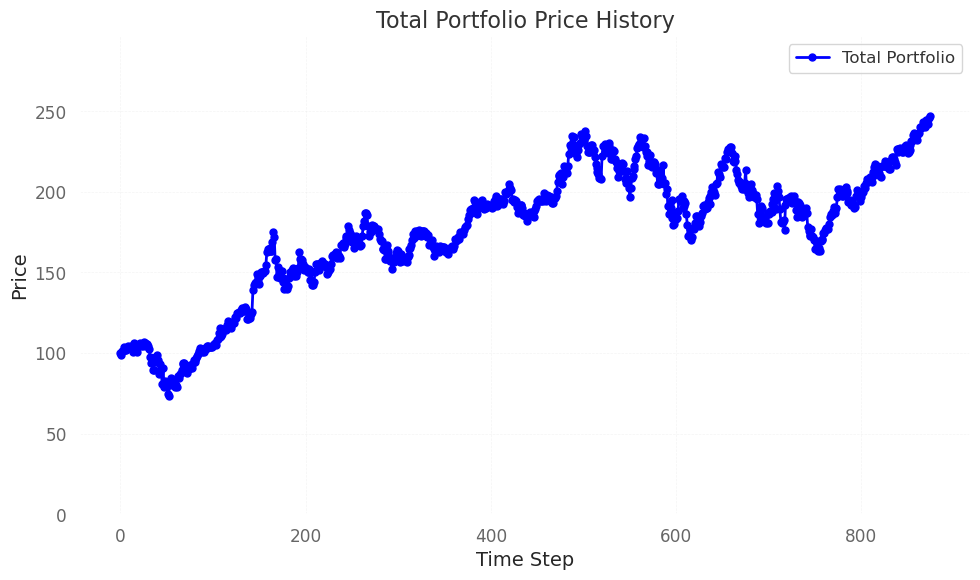

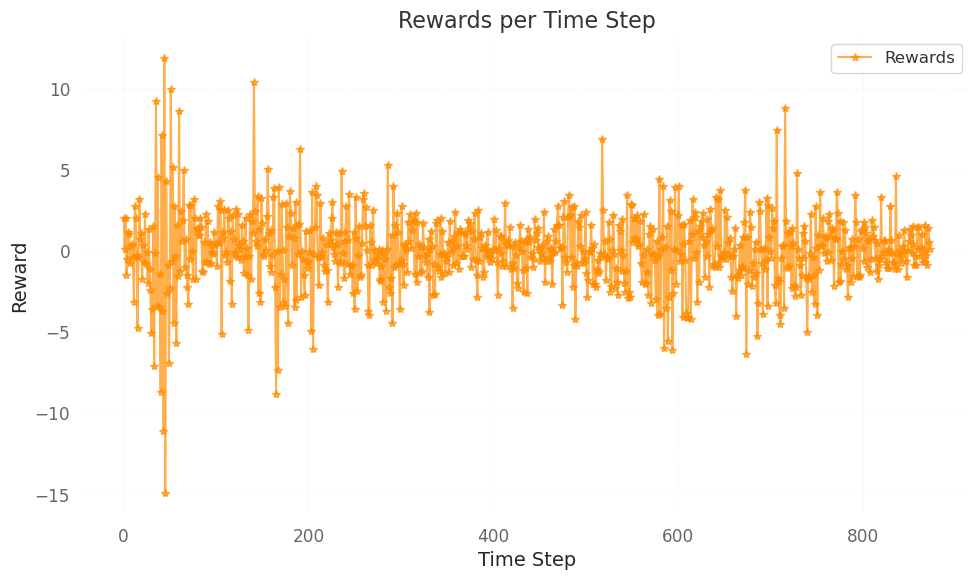

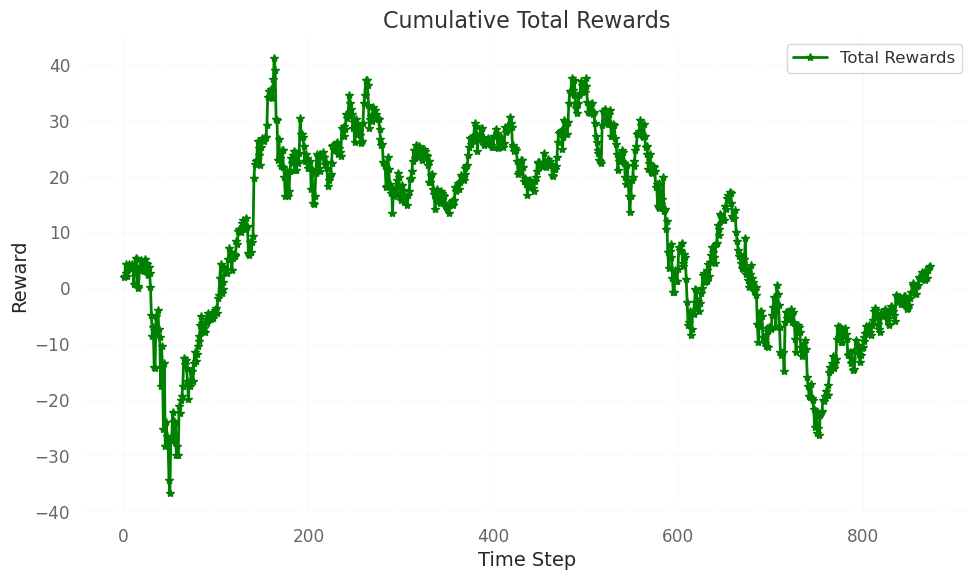

Total rewards: 3.8361744111676725
PPO Valid Mean reward: 1.70 ± 0.00
PPO
Total return of portfolio: -30.18%


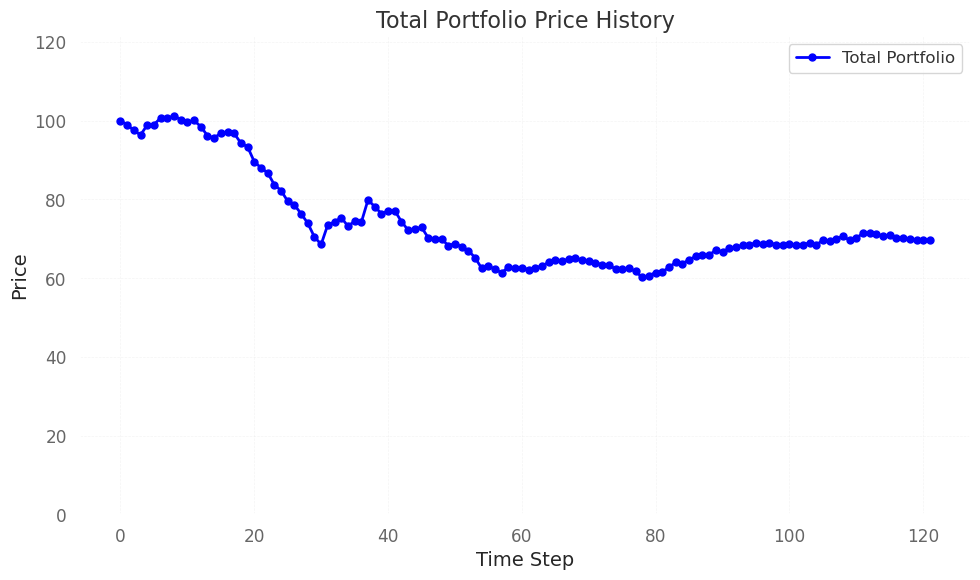

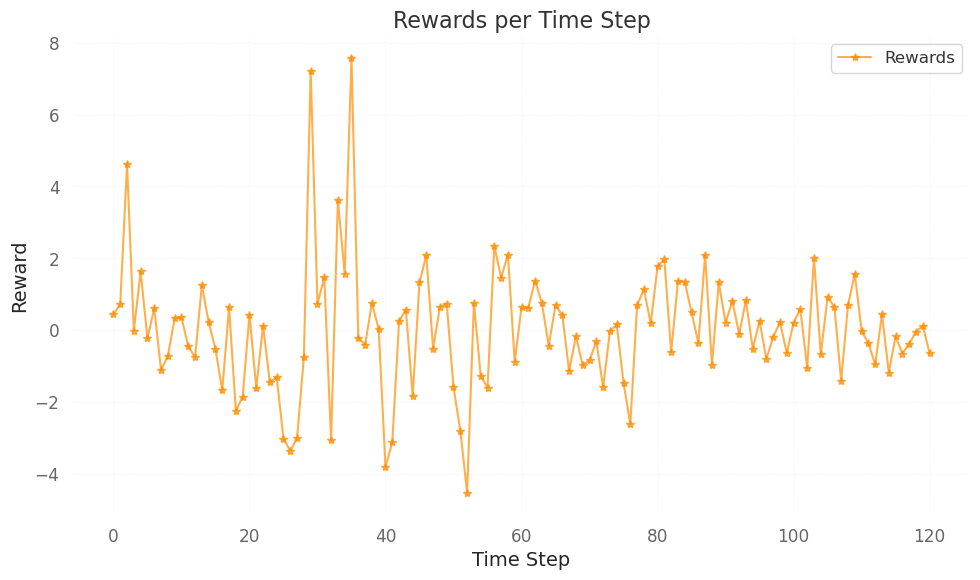

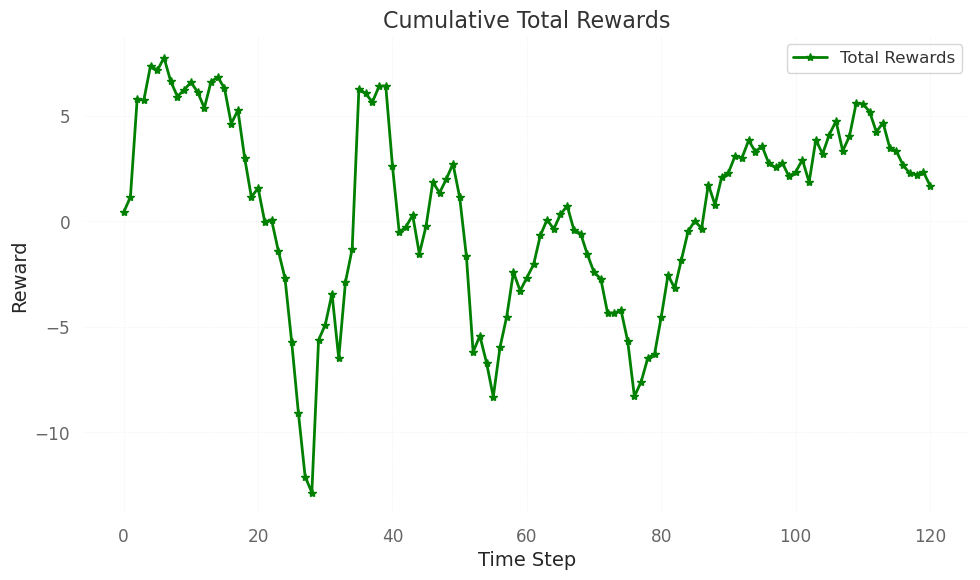

Total rewards: 1.6954612697988964
PPO Test Mean reward: 2.16 ± 0.00

PPO
Total return of portfolio: 25.34%


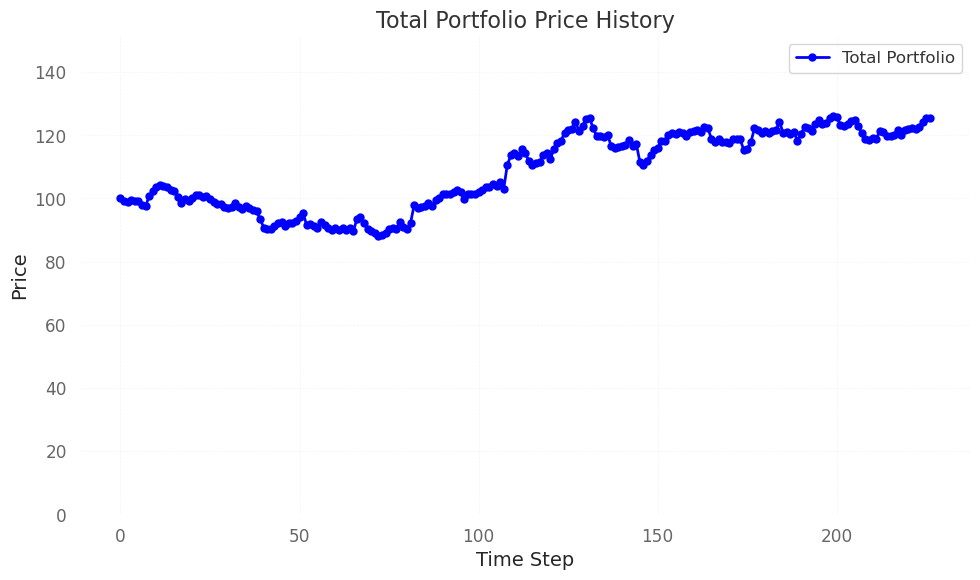

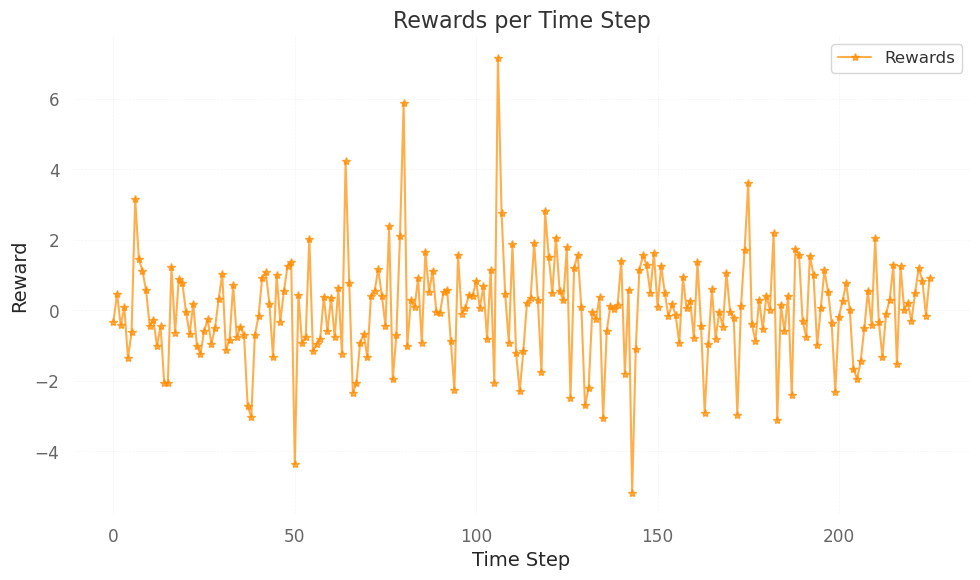

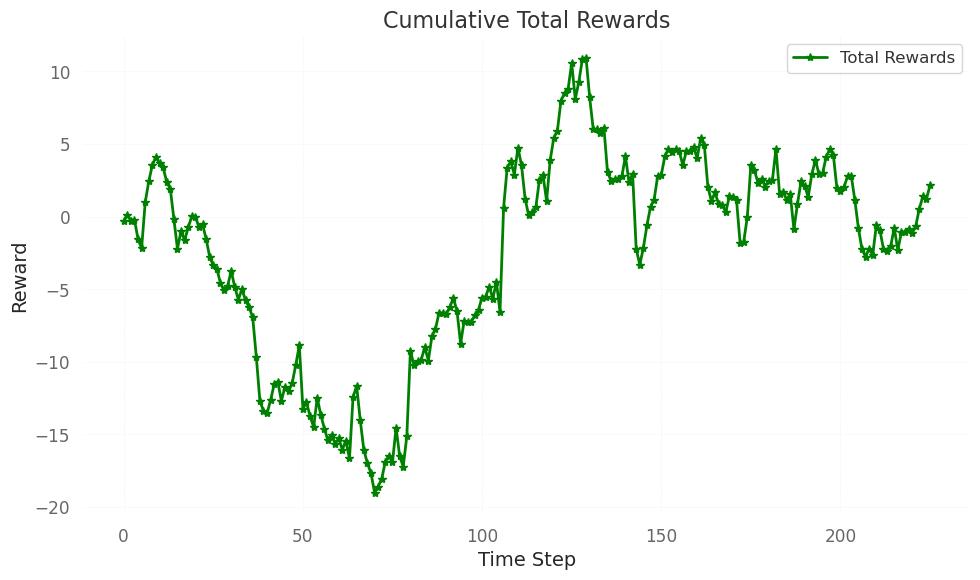

Total rewards: 2.1551801495139764


In [8]:
import datetime
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement

# Define constants
SEED = 1
history_length = 5
reward_type = 'LNR'
stocks = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
n_envs = 8
n_steps = 16
total_timesteps = 200_000
batch_size = 32
learning_rate = 0.02
ent_coef = 0.05
log_interval = 1_000
eval_freq = 1_000

current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_save_dir = f'./models/model_{current_date}'
log_dir = f'./logs/log_{current_date}'

# Training environment
env, vec_env = create_training_env(history_length, reward_type, '2020-01-01', '2023-06-30', stocks, n_envs)

# Validation environment
valid_env, vec_valid_env = create_evaluation_env(history_length, reward_type, '2023-07-01', '2023-12-30', stocks)

# Test environment
test_env, _ = create_evaluation_env(history_length, reward_type, '2024-01-01', '2024-12-01', stocks, n_envs=1)

# Evaluation callback for saving the best model
eval_callback = EvalCallback(
    vec_valid_env,
    n_eval_episodes=1,
    eval_freq=eval_freq,
    deterministic=True,
    verbose=0,
    best_model_save_path=model_save_dir,
)
stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)

# Models to test
models_to_test = [
    "PPO" ,
    #"A2C", 
    #"DQN",
    #"DDPG",
    #"SAC",
    #"TD3",
    #"TRPO",
    #"QRDQN",
    #"MaskablePPO",
    #"RecurrentPPO",
    #"ARS",
    #"HER",
    #"BC",
    #"SQIL",
    #"GAIL",
    #"AIRL"
]

# Train and evaluate all models
for model_name in models_to_test:
    try:
        print(f"Testing model: {model_name}")
        
        # HER requires a single env
        if model_name == "HER":
            trained_model = train_model(
                model_name=model_name,
                create_model=True,
                env=env,
                train_timesteps=total_timesteps,
                log_frec=log_interval,
                log_base_dir=log_dir,
                n_steps=n_steps,
                batch_size=batch_size,
                learning_rate=learning_rate,
                ent_coef=ent_coef,
                seed=SEED
            )
        # BC, SQIL, GAIL, and AIRL require transitions
        elif model_name in ["BC", "SQIL", "GAIL", "AIRL"]:
            transitions, expert_actions = collect_expert_data(env, seed=SEED)
            trained_model = train_model(
                model_name=model_name,
                create_model=True,
                vec_env=vec_env if model_name != "BC" else None,
                env=env if model_name == "BC" else None,
                transitions=transitions,
                train_timesteps=total_timesteps,
                log_frec=log_interval,
                log_base_dir=log_dir,
                n_steps=n_steps,
                batch_size=batch_size,
                learning_rate=learning_rate,
                ent_coef=ent_coef,
                seed=SEED,
                bc_batches = total_timesteps
            )
        # RL models (e.g., PPO, A2C, etc.) use vec_env
        else:
            trained_model = train_model(
                model_name=model_name,
                create_model=True,
                callback = eval_callback,
                vec_env=vec_env,
                train_timesteps=total_timesteps,
                log_frec=log_interval,
                log_base_dir=log_dir,
                n_steps=n_steps,
                batch_size=batch_size,
                learning_rate=learning_rate,
                ent_coef=ent_coef,
                seed=SEED,
                #policy_kwargs = dict(activation_fn=th.nn.ReLU,
                 #    net_arch=dict(pi=[32, 32], vf=[32, 32]))
            )
        
        # Evaluate the model on training and test environments
        print(f"Evaluating model: {model_name}")
        
        # Training evaluation
        mean_train_reward, std_train_reward = evaluate_policy(
            trained_model.policy if hasattr(trained_model, 'policy') else trained_model,
            env,
            n_eval_episodes=10,
            deterministic=True
        )
        print(f"{model_name} Train Mean reward: {mean_train_reward:.2f} ± {std_train_reward:.2f}")
        evaluate_model(env, trained_model, model_name, 1, has_policy=True) if hasattr(trained_model, 'policy') else evaluate_model(env, trained_model, model_name, 1, has_policy=False)
        
        # Valid evaluation
        mean_valid_reward, std_valid_reward = evaluate_policy(
            trained_model.policy if hasattr(trained_model, 'policy') else trained_model,
            valid_env,
            n_eval_episodes=10,
            deterministic=True
        )
        print(f"{model_name} Valid Mean reward: {mean_valid_reward:.2f} ± {std_valid_reward:.2f}")
        evaluate_model(valid_env, trained_model, model_name, 1, has_policy=True) if hasattr(trained_model, 'policy') else evaluate_model(valid_env, trained_model, model_name, 1, has_policy=False)
        
        # Test evaluation
        mean_test_reward, std_test_reward = evaluate_policy(
            trained_model.policy if hasattr(trained_model, 'policy') else trained_model,
            test_env,
            n_eval_episodes=10,
            deterministic=True
        )
        print(f"{model_name} Test Mean reward: {mean_test_reward:.2f} ± {std_test_reward:.2f}\n")
        evaluate_model(test_env, trained_model, model_name, 1, has_policy=True) if hasattr(trained_model, 'policy') else evaluate_model(test_env, trained_model, model_name, 1, has_policy=False)
    except Exception as error:
        print(f"Model {model_name} did not work because of {error}. Skipping to the next model...\n")


In [ ]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

# Wrapping environments with `Monitor`
env, vec_env = create_training_env(history_length, reward_type, '2020-01-01', '2023-06-30', stocks, n_envs)
vec_env = DummyVecEnv([lambda: Monitor(env)])
valid_env, vec_valid_env = create_evaluation_env(history_length, reward_type, '2023-07-01', '2023-12-30', stocks)
vec_valid_env = DummyVecEnv([lambda: Monitor(valid_env)])
test_env, _ = create_evaluation_env(history_length, reward_type, '2024-01-01', '2024-10-30', stocks, n_envs=1)
test_env = Monitor(test_env)

# List of models to test
models_to_test = [
    "PPO", "A2C", "DQN", "DDPG", "SAC", "TD3",
    "TRPO", "QRDQN", "MaskablePPO", "RecurrentPPO", "ARS",
    "HER", "BC", "SQIL", "GAIL", "AIRL"
]

# Train and evaluate all models
for model_name in models_to_test:
    try:
        print(f"Testing model: {model_name}")
        
        # Skip models incompatible with discrete action spaces
        if model_name in ["DDPG", "SAC", "TD3"] and isinstance(env.action_space, gym.spaces.Discrete):
            print(f"Model {model_name} skipped due to incompatible action space.\n")
            continue

        # HER requires single env
        if model_name == "HER":
            trained_model = train_model(
                model_name=model_name,
                create_model=True,
                env=env,
                train_timesteps=total_timesteps,
                log_frec=log_interval,
                log_base_dir=log_dir,
                n_steps=n_steps,
                batch_size=batch_size,
                learning_rate=learning_rate,
                ent_coef=ent_coef,
                seed=SEED
            )
        # BC, SQIL, GAIL, and AIRL require transitions
        elif model_name in ["BC", "SQIL", "GAIL", "AIRL"]:
            transitions, expert_actions = collect_expert_data(env, seed=SEED)
            trained_model = train_model(
                model_name=model_name,
                create_model=True,
                vec_env=vec_env if model_name != "BC" else None,
                env=env if model_name == "BC" else None,
                transitions=transitions,
                train_timesteps=total_timesteps,
                log_frec=log_interval,
                log_base_dir=log_dir,
                n_steps=n_steps,
                batch_size=batch_size,
                learning_rate=learning_rate,
                ent_coef=ent_coef,
                seed=SEED,
                demo_batch_size=32,  # Fix for GAIL and AIRL
            )
        # RL models (e.g., PPO, A2C, etc.)
        else:
            trained_model = train_model(
                model_name=model_name,
                create_model=True,
                vec_env=vec_env,
                train_timesteps=total_timesteps,
                log_frec=log_interval,
                log_base_dir=log_dir,
                n_steps=n_steps,
                batch_size=batch_size,
                learning_rate=learning_rate,
                ent_coef=ent_coef,
                seed=SEED
            )
        
        # Evaluate the model
        print(f"Evaluating model: {model_name}")
        mean_train_reward, std_train_reward = evaluate_policy(trained_model.policy, vec_env, n_eval_episodes=10)
        mean_test_reward, std_test_reward = evaluate_policy(trained_model.policy, test_env, n_eval_episodes=10)
        print(f"{model_name} Train Reward: {mean_train_reward:.2f} ± {std_train_reward:.2f}")
        print(f"{model_name} Test Reward: {mean_test_reward:.2f} ± {std_test_reward:.2f}\n")

    except Exception as error:
        print(f"Model {model_name} did not work because of {error}. Skipping to the next model...\n")


Testing model: PPO
Using cpu device
Logging to ./logs/log_2024-11-27_18-06-59/RL_0_run_6


/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 16, but because the `RolloutBuffer` is of size `n_steps * n_envs = 8`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=8 and n_envs=1)
  warnings.warn(


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 874       |
|    ep_rew_mean          | 1.44e+03  |
| time/                   |           |
|    fps                  | 107       |
|    iterations           | 1000      |
|    time_elapsed         | 74        |
|    total_timesteps      | 8000      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.79e-21 |
|    explained_variance   | 0         |
|    learning_rate        | 0.02      |
|    loss                 | 1.66e+04  |
|    n_updates            | 9990      |
|    policy_gradient_loss | -3.58e-08 |
|    value_loss           | 3.36e+04  |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 874       |
|    ep_rew_mean          | 1.57e+03  |


RL

Using cpu device
Logging to ./logs/log_2024-12-11_19-43-06/RL_0_run_1
Train
Total return of portfolio: 48.98%


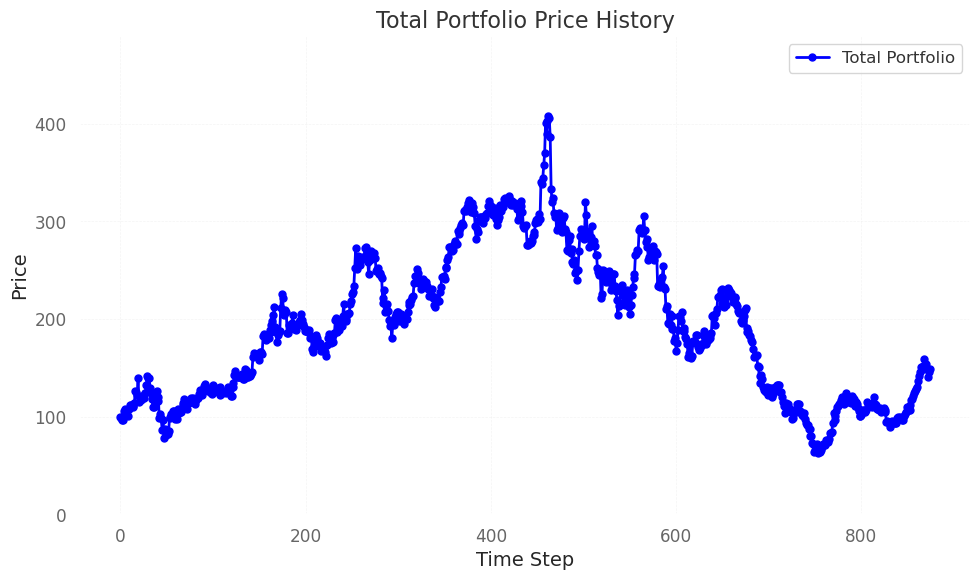

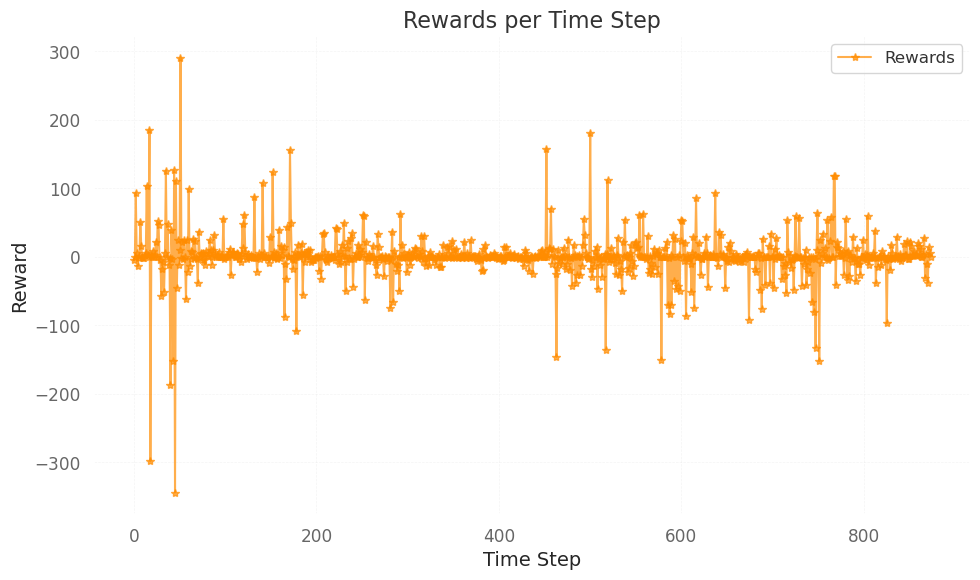

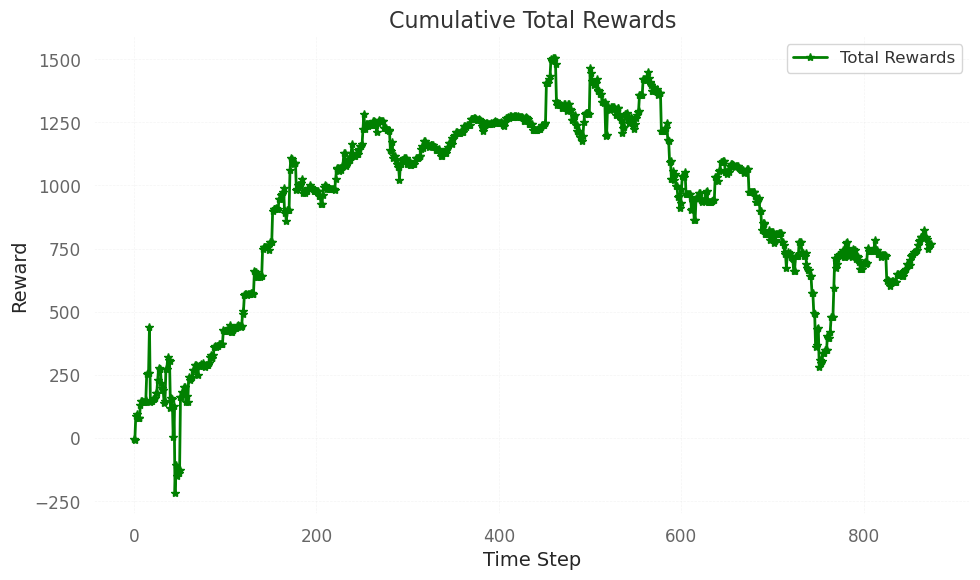

Total rewards: 768.6105499230084
Valid
Total return of portfolio: -56.26%


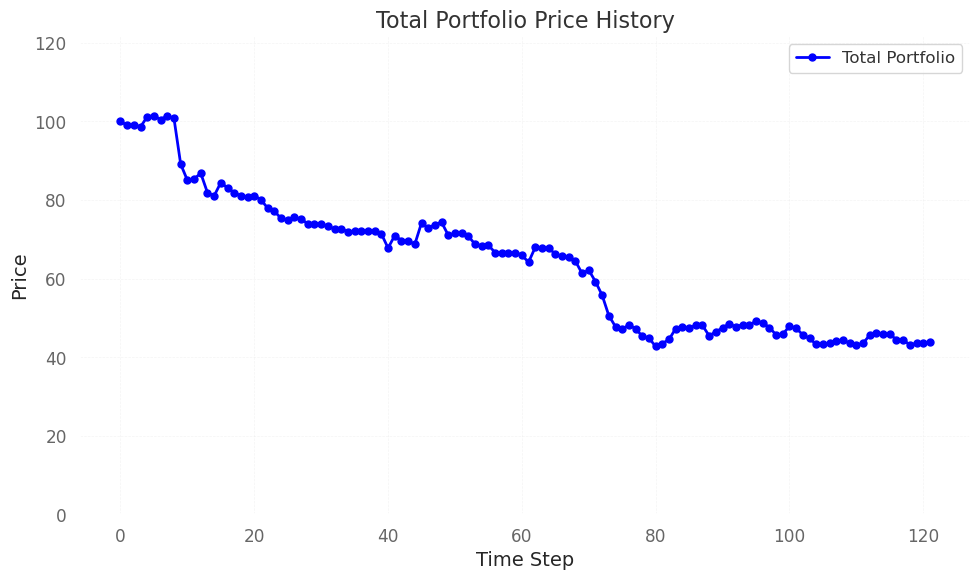

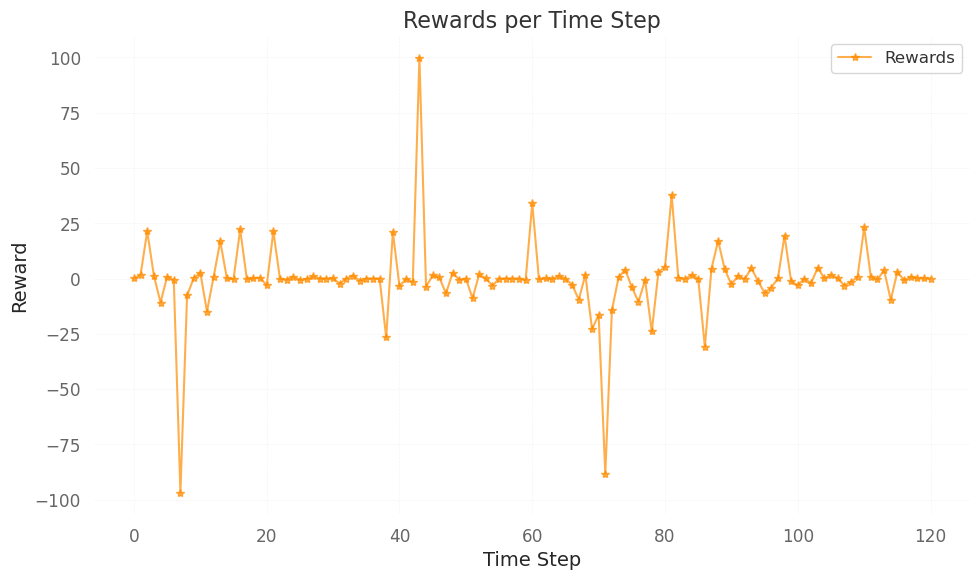

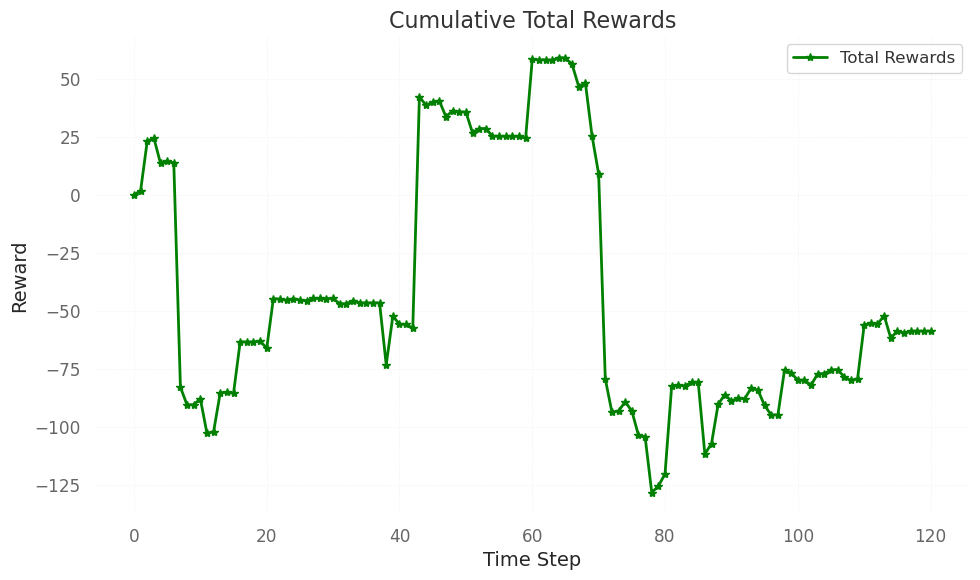

Total rewards: -58.78243363383997
Test
Total return of portfolio: 111.44%


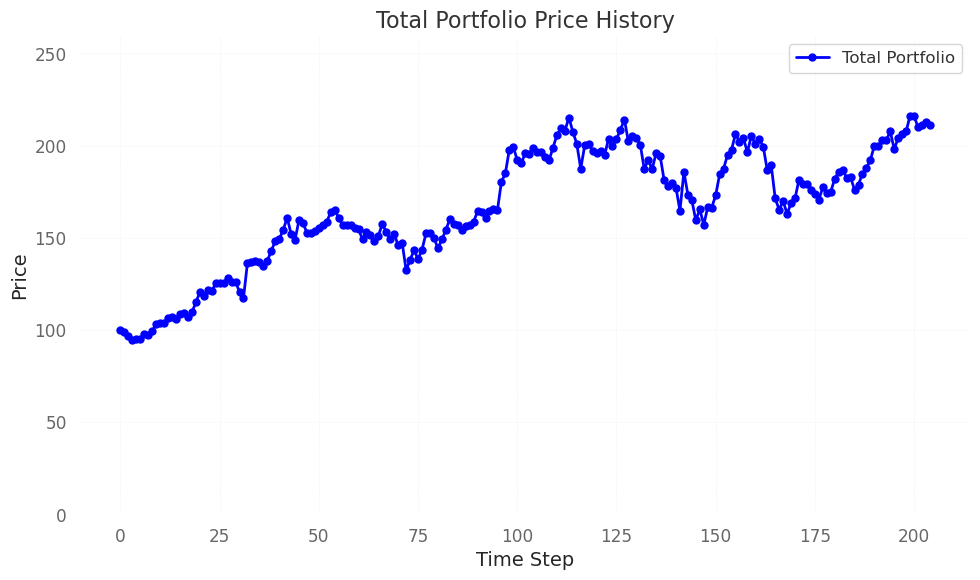

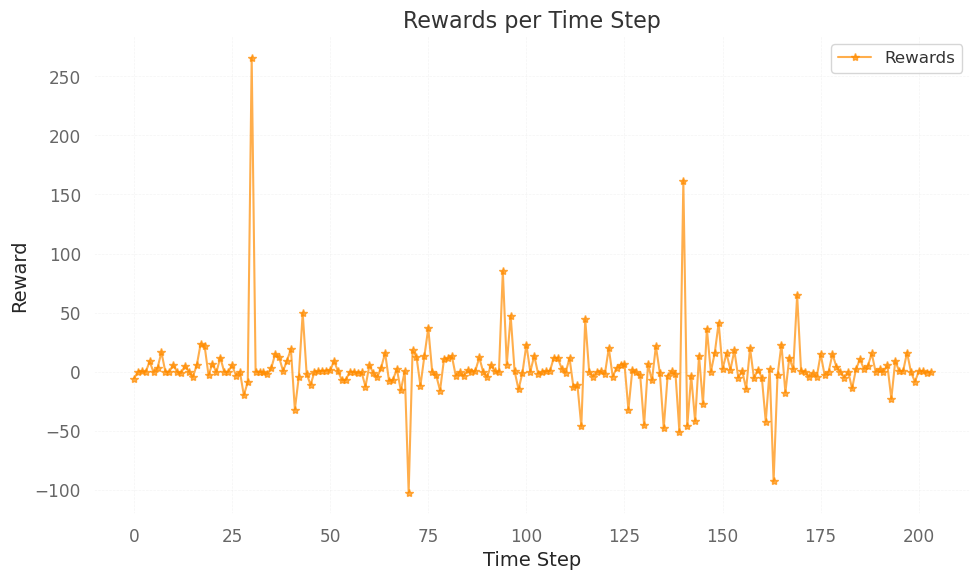

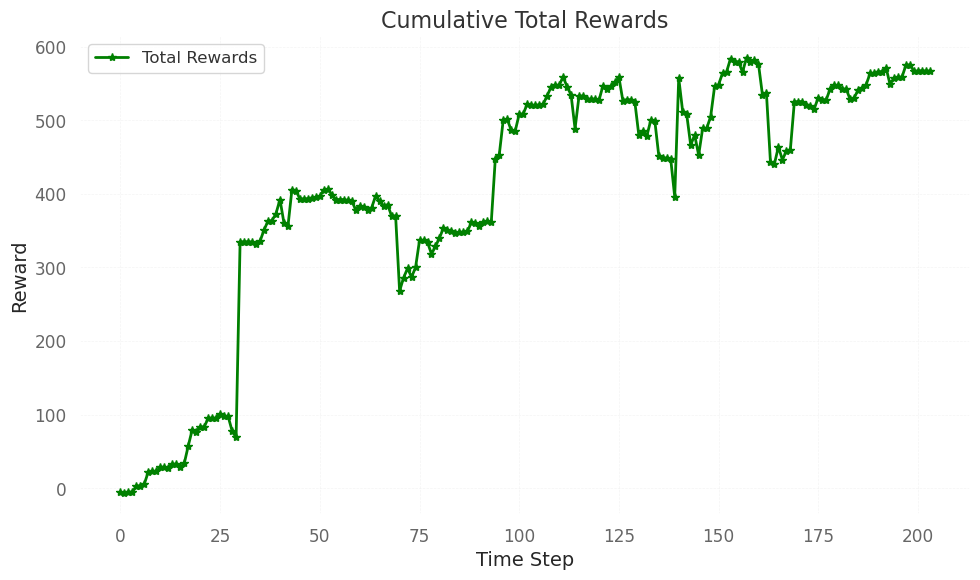

Total rewards: 566.745630755232


In [5]:
# Define constants
SEED = 1
history_length = 5
reward_type = 'LNR'
stocks = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
n_envs = 10
n_steps = 8
total_timesteps = 10_000
batch_size = 16
learning_rate = 0.001
ent_coef = 0.10
log_interval = 1_000
eval_freq=1_000

current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_save_dir = f'./models/model_{current_date}'
log_dir = f'./logs/log_{current_date}'

# Training environment
env, vec_env = create_training_env(history_length, reward_type, '2020-01-01', '2023-06-30', stocks, n_envs)

# Validation environment
valid_env, vec_valid_env = create_evaluation_env(history_length, reward_type, '2023-07-01', '2023-12-30', stocks)

# Test environment
test_env, _ = create_evaluation_env(history_length, reward_type, '2024-01-01', '2024-10-30', stocks, n_envs=1)

# Evaluation callback for saving the best model
eval_callback = EvalCallback(
    vec_valid_env,
    n_eval_episodes=1,
    eval_freq=eval_freq,
    deterministic=True,
    verbose=1,
    best_model_save_path=model_save_dir,
)
stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)

# Train the model
model = train_model(
    model_name="PPO",  # Can be 'PPO', 'A2C', or 'DQN'
    create_model=True,
    vec_env=vec_env,
    iterations=1,
    train_timesteps=total_timesteps,
    log_frec=log_interval,
    log_base_dir=log_dir,
    n_steps=n_steps,
    batch_size=batch_size,
    learning_rate=learning_rate,
    ent_coef=ent_coef
)

# Evaluate the model
evaluate_model(env, model, 'Train', SEED, has_policy=False)
evaluate_model(valid_env, model, 'Valid', SEED, has_policy=False)
evaluate_model(test_env, model, 'Test', SEED, has_policy=False)

# Save the model to the Tests folder
save_model(model, model_save_dir)

# Close environments
env.close()
valid_env.close()
test_env.close()
vec_env.close()
vec_valid_env.close()

BC

In [5]:
# Define constants
SEED = 1
history_length = 5
reward_type = 'LNR'
stocks = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
n_envs = 1
n_steps = 8
total_timesteps = 10_000
batch_size = 64
learning_rate = 0.001
ent_coef = 0.10
log_interval = 10_000
eval_freq=1_000
log_dir = './logs'
model_save_dir = './models'

# Training environment
env, vec_env = create_training_env(history_length, reward_type, '2023-05-01', '2023-06-30', stocks, n_envs)
valid_env, vec_valid_env = create_training_env(history_length, reward_type, '2023-07-01', '2023-08-30', stocks, 1)
transitions, expert_actions = collect_expert_data(env, seed=SEED)
bc_trainer = train_model(
    model_name="BC",
    create_model=True,
    env=env,
    transitions=transitions,
    bc_batches=2000,
    bc_log_interval=1_000,
    batch_size=118,
    seed=1
)
model_actions, returns, total_reward = evaluate_model(env, name="BC",has_policy=True,SEED=SEED,trainer=bc_trainer)
action_counts = pd.Series(model_actions).value_counts()
print("Action Counts:")
print(action_counts)
model_actions, returns, total_reward = evaluate_model(valid_env, name="BC",has_policy=True,SEED=SEED,trainer=bc_trainer)
action_counts = pd.Series(model_actions).value_counts()
print("Action Counts:")
print(action_counts)
best_actions, best_returns, total_reward = evaluate_best(env, expert_actions, SEED)
action_counts = pd.Series(best_actions).value_counts()
print("Action Counts:")
print(action_counts)

# Close environments
env.close()
valid_env.close()
vec_env.close()
vec_valid_env.close()

TypeError: train_model() got an unexpected keyword argument 'bc_log_interval'

Final Portfolio Value: $13344.76
Percentage Return: 33.45%


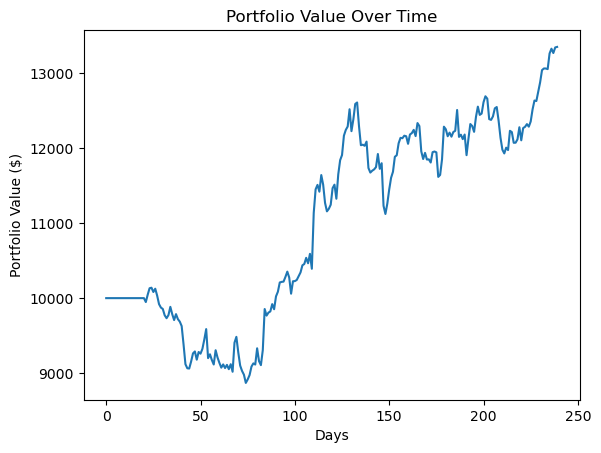

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Fetch stock data from yfinance
def fetch_stock_data(tickers, start_date, end_date):
    data = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)
        if not df.empty:
            df['Pct_Change'] = df['Close'].pct_change()
            data[ticker] = df.dropna()  # Remove rows with NaN
    return data

# Dataset for stock trading
class StockTradingDataset(Dataset):
    def __init__(self, stock_data, seq_len):
        self.data = []
        self.seq_len = seq_len
        self.scaler = MinMaxScaler()

        for ticker, df in stock_data.items():
            features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Pct_Change']].values
            features = self.scaler.fit_transform(features)  # Normalize features
            for i in range(len(features) - seq_len - 1):
                x = features[i:i + seq_len, :-1]  # Input features
                y = features[i + seq_len, -1]    # Target (Pct_Change)
                self.data.append((x, y))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Transformer model
class StockSelectorTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, ff_dim, output_dim, max_len, dropout=0.1):
        super(StockSelectorTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(self._generate_positional_encoding(max_len, embed_dim), requires_grad=False)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, output_dim)

    def _generate_positional_encoding(self, seq_len, embed_dim):
        position = torch.arange(0, seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(torch.log(torch.tensor(10000.0)) / embed_dim))
        pe = torch.zeros(seq_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)
        x += self.positional_encoding[:, :seq_len, :]
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, embed_dim)
        x = self.encoder(x)
        x = x.mean(dim=0)
        scores = self.fc(x)
        return scores

# Simulate trading
def simulate_trading(model, stock_data, seq_len, start_cash=10000):
    model.eval()
    cash = start_cash
    portfolio = 0
    daily_values = []
    stocks_held = {}

    for ticker, df in stock_data.items():
        df['Predicted_Change'] = np.nan
        features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Pct_Change']].values
        scaler = MinMaxScaler()
        features = scaler.fit_transform(features)
        for i in range(seq_len, len(features)):
            x = torch.tensor(features[i - seq_len:i, :-1], dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                prediction = model(x).item()
            df.loc[df.index[i], 'Predicted_Change'] = prediction

    for date in stock_data[tickers[0]].index:
        daily_portfolio = 0
        for ticker, df in stock_data.items():
            if date not in df.index:
                continue
            row = df.loc[date]
            predicted_change = row['Predicted_Change']
            current_price = row['Close']

            if predicted_change > 0 and cash > current_price:
                num_shares = cash // current_price
                cash -= num_shares * current_price
                stocks_held[ticker] = stocks_held.get(ticker, 0) + num_shares

            if ticker in stocks_held:
                daily_portfolio += stocks_held[ticker] * current_price

        total_value = cash + daily_portfolio
        daily_values.append(total_value)

    percentage_return = (daily_values[-1] - start_cash) / start_cash * 100
    print(f"Final Portfolio Value: ${daily_values[-1]:.2f}")
    print(f"Percentage Return: {percentage_return:.2f}%")

    plt.plot(daily_values)
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Days")
    plt.ylabel("Portfolio Value ($)")
    plt.show()

    return percentage_return

# Main function
if __name__ == "__main__":
    tickers = ["AAPL", "MSFT", "GOOGL"]
    seq_len = 20

    # Fetch training data (2020-2023)
    train_stock_data = fetch_stock_data(tickers, "2020-01-01", "2023-12-31")

    # Fetch testing data (2024)
    test_stock_data = fetch_stock_data(tickers, "2024-01-01", "2024-12-31")

    # Create datasets and dataloaders
    train_dataset = StockTradingDataset(train_stock_data, seq_len)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = StockTradingDataset(test_stock_data, seq_len)

    # Model parameters
    input_dim = 5
    embed_dim = 64
    num_heads = 4
    num_layers = 2
    ff_dim = 128
    output_dim = 1
    max_len = seq_len
    dropout = 0.1

    # Instantiate model
    model = StockSelectorTransformer(
        input_dim=input_dim,
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        ff_dim=ff_dim,
        output_dim=output_dim,
        max_len=max_len,
        dropout=dropout
    )

    # Training setup
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(100):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = criterion(predictions.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        #print(f"Epoch {epoch + 1}, Train Loss: {total_train_loss:.4f}")

    # Simulate trading on test data (2024)
    simulate_trading(model, test_stock_data, seq_len)